# TurkishSpamFilterEnhancement-NLP

# Let's Import the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

C:\Users\bahra\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
#Reading CSV file as pandas Dataframe
df = pd.read_csv("archive/trspam.csv", header=None, encoding="utf-8", on_bad_lines='skip')
df

,0,1,2
0,0.0,0.0,NaN
1,"Sayın Yetkili ,\n Gelişen ve değişen günümüz ...",spam,NaN
2,"Sayın Yetkili,\n \n28 Kasım 2010 tarihli KPSS ...",spam,NaN
3,"Sayın Yetkili ,\n Gelişen ve değişen günümüz ...",spam,NaN
4,T.C.\nURLA KAYMAKAMLIĞI\nURLA HAKAN ÇEKEN ANAD...,spam,NaN
...,...,...,...
698,Ã¶zlem sent you a message.\n\n(no subject)\n\n...,ham,NaN
699,"Sayın Hocalarım, değerli zamanınızı aldığım iç...",ham,NaN
700,PGh0bWw+DQo8aGVhZD4NCjx0aXRsZT5DaGlwJmFtcDtQSU...,ham,NaN
701,PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...,ham,NaN


# Dataset Cleaning and Reshaping Processes

In [3]:
#Removing na values from dataframe
def dt_na_value_cleaning(data):
    print("\nData Shape : ", data.shape)
    print("\nNull values before removal:: ")
    print(data.isna().sum())
    
    data.dropna(inplace=True)
    data.reset_index(inplace=True,drop=True)
    
    print("\nNull values after removal: ")
    print(data.isna().sum())
    print("\nData Shape after cleaning :" , data.shape)
    
    return data

In [4]:
 # Removing duplicate values
def duplicate_content_removal(dt, col, ini_row):
    dt = dt.iloc[1: , :]
    print("\nNumber of data before removing duplicates: ",ini_row)
    duplicate_count = dt[col].duplicated().sum()
    print("\nNumber of Duplicates: ", duplicate_count)
    
    description_data = dt[col].drop_duplicates()
    cleaned_row = len(description_data)
 
    if (ini_row - cleaned_row) > 0:
        print("\nTotal data reduction : ", (ini_row - cleaned_row))
        print("\nNumber of data after removing duplicates is :", cleaned_row)
    else:
        print("\nNo duplicate data.")
    return list(description_data)             

In [5]:
df=df.rename(columns={0: "E_Mail", 1: "Label", 2:"NaN"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   E_Mail  701 non-null    object 
 1   Label   702 non-null    object 
 2   NaN     1 non-null      float64
dtypes: float64(1), object(2)
memory usage: 16.6+ KB


In [6]:
#deleting the unnecessary columns and rows
del df["NaN"]
df = df.iloc[1: , :]
df = df.replace(r'\n',' ', regex=True)
df = dt_na_value_cleaning(df)
E_Mail = duplicate_content_removal(df, 'E_Mail', df.shape[
0])
df.shape
df['Label'].value_counts(normalize=True)# Removing duplicate values


Data Shape :  (702, 2)

Null values before removal:: 
E_Mail    2
Label     1
dtype: int64

Null values after removal: 
E_Mail    0
Label     0
dtype: int64

Data Shape after cleaning : (700, 2)

Number of data before removing duplicates:  700

Number of Duplicates:  66

Total data reduction :  67

Number of data after removing duplicates is : 633


ham     0.594286
spam    0.405714
Name: Label, dtype: float64

In [ ]:
# Check if JVM is already running
if not jpype.isJVMStarted():
    # Start the JVM
    startJVM(jpype.getDefaultJVMPath(), '-ea', '-Djava.class.path=%s' % ZEMBEREK_PATH)

In [ ]:
def lemmatizer(text):
    TurkishMorphology = JClass('zemberek.morphology.TurkishMorphology')
    morphology = TurkishMorphology.createWithDefaults()
    analysis: java.util.ArrayList = (morphology.analyzeAndDisambiguate(text).bestAnalysis())
    pos: List[str] = []
    
    for i, analysis in enumerate(analysis, start=1):
        f'\nAnalysis {i}: {analysis}',
        f'\nPrimary POS {i}: {analysis.getPos()}'
        f'\nPrimary POS (Short Form) {i}: {analysis.getPos().shortForm}'
        
        pos.append(f'{str(analysis.getLemmas()[0])}') 
    return " ".join(pos)

In [ ]:
#applying cleaning functions to training data set one at a time to check the results
df["E_Mail"] = df["E_Mail"].apply(trlower)
df["E_Mail"] = df["E_Mail"].apply(sayi)
df["E_Mail"] = df["E_Mail"].apply(noktalama)
df["E_Mail"] = df["E_Mail"].apply(wspace)

#Removing Turkish stopwords with NLTK library
df['E_Mail'] = df['E_Mail'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

df['E_Mail'] = df['E_Mail'].str.split().apply(remove_length)

df["E_Mail"] = df["E_Mail"].apply(lemmatizer)
#since ZEMBEREK lemmatizer gives UNK as output 
# if a word cannot be processed, replacing it with ‘’

df["E_Mail"] = df["E_Mail"].str.replace("UNK", '')
df.head()

# EDA

## 1. Data Overview: 

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E_Mail  700 non-null    object
 1   Label   700 non-null    object
dtypes: object(2)
memory usage: 11.1+ KB
None


## 2. Label Distribution:

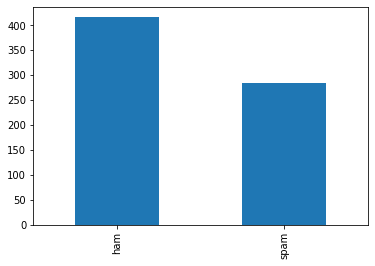

In [8]:
df['Label'].value_counts().plot(kind='bar')
plt.show()

## 3. Text Length Analysis:

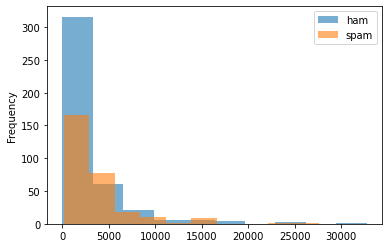

In [9]:
df['text_length'] = df['E_Mail'].apply(len)
df.groupby('Label')['text_length'].plot(kind='hist', alpha=0.6)
plt.legend()
plt.show()

## 4. Word Frequency Analysis

[('ve', 5349), ('3d', 3380), ('com', 3309), ('bir', 2292), ('c4', 2235), ('20', 2109), ('fd', 2007), ('bu', 1696), ('hotmail', 1560), ('nbsp', 1439), ('tr', 1385), ('c3', 1254), ('http', 1203), ('td', 1198), ('de', 1084), ('style', 1002), ('font', 988), ('br', 942), ('dd', 875), ('the', 800)]


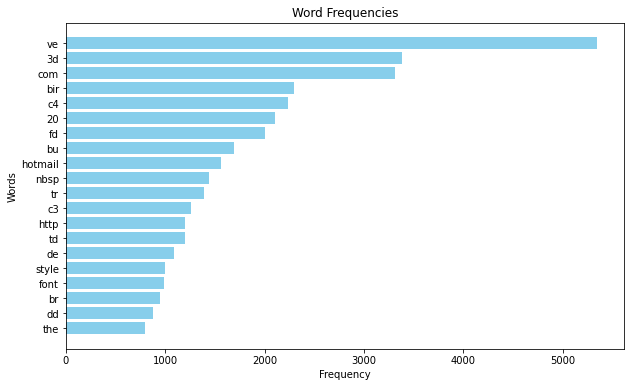

In [10]:
cv = CountVectorizer(max_features=20)
word_count = cv.fit_transform(df['E_Mail'])
sum_words = word_count.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print(words_freq)
# Convert list of tuples into a DataFrame
df2 = pd.DataFrame(words_freq, columns=['Word', 'Frequency'])

# Plot
plt.figure(figsize=(10,6))
plt.barh(df2['Word'], df2['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Word Frequencies')
plt.gca().invert_yaxis()  # Reverse the order of words
plt.show()

## 5. Word Cloud:

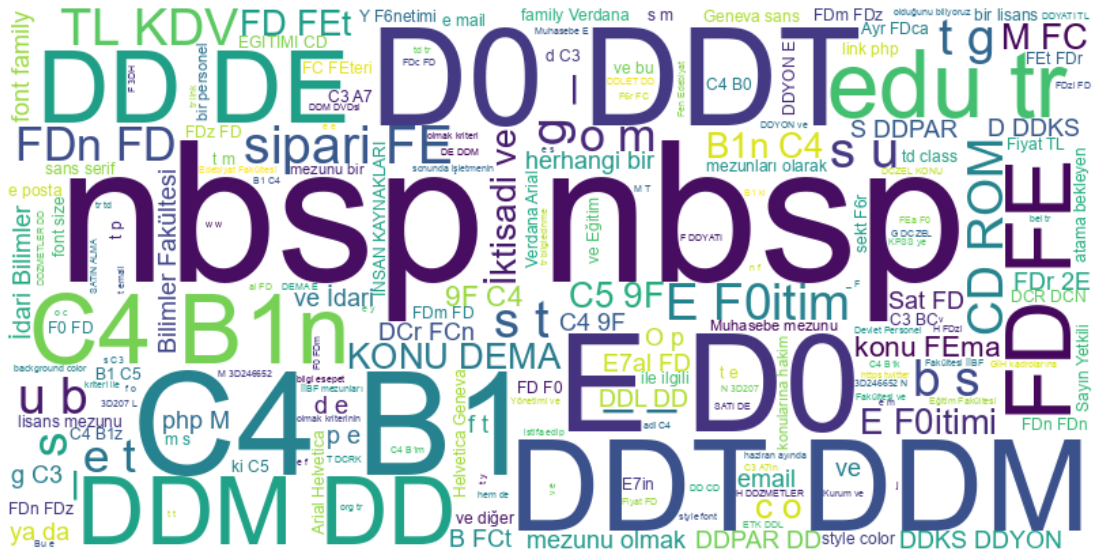

In [11]:
spam_words = ' '.join(list(df[df['Label']=='spam']['E_Mail']))
spam_wc = WordCloud(background_color="white", width=800, height=400, font_path='C:\\Windows\\Fonts\\arial.ttf').generate(spam_words)

plt.figure(figsize=(30, 10))
plt.imshow(spam_wc, interpolation="bilinear")
plt.axis("off")
plt.show()


## Analysis

* As we can see there are a lot of useless word in the dataset, they are not even `stopwords`
* We will be doing data cleaning and also preprocessing to make the dataset useable for our practice.